# Homework 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cv2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

---
# Часть 1: Свертки

## Реализация

В этом разделе вы реализуете две версии свертки:
- `conv_nested`
- `conv_fast`

Сначала запустите нижеуказанную кодовую ячейку, чтобы загрузить изображение для работы.

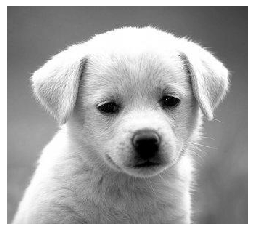

In [2]:
# Open image as grayscale
img = cv2.imread('img/dog.jpg', 0)

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()

Теперь реализуем функцию **`conv_nested`** в **`filters.py`**. Это наивная реализация convolution, использующая 4 вложенных for-loops. В качестве входа и выхода она берет изображение $f$ и ядро $h$, которое имеет ту же форму, что и входное изображение. Запуск этой реализации должен занять несколько секунд.

*- Подсказка: Возможно, будет проще реализовать $(h*f)$*.

Сначала мы протестируем вашу функцию `conv_nested` на простом входе.

In [3]:
def conv_nested(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    kernel = np.flip(np.flip(kernel,axis=1),axis=0)
    out = np.zeros((Hi, Wi))
    
    
    bh = int((Hk-1)/2)
    bw = int((Wk-1)/2)
    for x in range(bh, Hi-bh):
        for y in range(bw, Wi -bw):
            for xk in range(-1*bh, bh+1):
                for yk in range(-1*bw, bw+1):
                    #проходимся по соседним ячейкам image[x][y](соседние в пределах ядра), чтобы найти взвешанную
                    out[x][y] += image[x + xk][y+yk] * kernel[xk+bh][yk+bw]
    return out

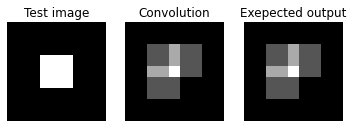

In [4]:
# Simple convolution kernel.
kernel = np.array(
[
    [1,0,1],
    [0,0,0],
    [1,0,0]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[5:, 5:] = 0
expected_output[4, 2:5] = 2
expected_output[2:5, 4] = 2
expected_output[4, 4] = 3

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

Теперь давайте протестируем вашу функцию `conv_nested` на реальном изображении.

In [5]:
def conv_nested2(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    image = np.pad(image, Hk // 2)
    
    for i in range(Hi):
        for j in range(Wi):
            for k in range(Hk):
                for l in range(Wk):
                    out[i, j] += image[i + k, j + l] * kernel[Hk - 1 - k, Wk - 1 - l]

    return out

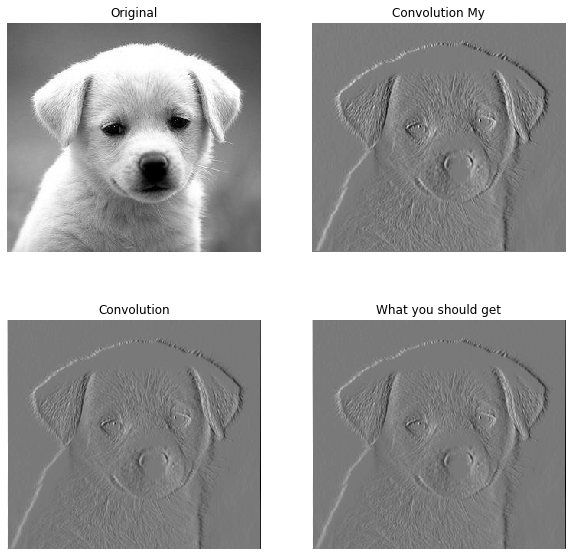

In [6]:
# from filters import conv_nested

# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1],
])

out = conv_nested2(img, kernel)
# out = cv2.filter2D(img, -1, kernel)

plt.figure(figsize=(10,10))
# Plot original image
plt.subplot(221), plt.imshow(img), plt.title('Original'), plt.axis('off')

# Plot your convolved image
plt.subplot(222), plt.imshow(conv_nested(img, kernel)), plt.title('Convolution My'), plt.axis('off')

# Plot your convolved image
plt.subplot(223), plt.imshow(out), plt.title('Convolution'), plt.axis('off')

# Plot what you should get
solution_img = cv2.imread('img/convoluted_dog.jpg', 0)
plt.subplot(224), plt.imshow(solution_img), plt.title('What you should get'), plt.axis('off')

plt.show()

In [7]:
out, solution_img

(array([[ 265.,   -3.,   -1., ...,    0.,   -3., -183.],
        [ 355.,   -4.,   -2., ...,    0.,   -3., -244.],
        [ 357.,   -3.,   -1., ...,   -1.,   -2., -244.],
        ...,
        [ 576.,    4.,   18., ...,    0.,   -4., -412.],
        [ 577.,   12.,   32., ...,    0.,   -4., -412.],
        [ 434.,   13.,   29., ...,    0.,   -3., -309.]]),
 array([[179, 121, 121, ..., 121, 121,  81],
        [199, 120, 121, ..., 121, 121,  68],
        [200, 121, 121, ..., 121, 121,  68],
        ...,
        [248, 121, 125, ..., 121, 120,  31],
        [248, 124, 128, ..., 121, 120,  31],
        [216, 124, 128, ..., 121, 121,  54]], dtype=uint8))

Реализуем более эффективный вариант свертки с использованием операций с массивами в numpy. Как показано в лекции, свертку можно рассматривать как скользящее окно, которое вычисляет сумму значений пикселей, взвешенных перевернутым ядром. Более быстрая версия: i) будет иметь нулевое изображение, ii) перевернёт ядро по горизонтали и вертикали, и iii) вычислит взвешенную сумму окрестностей в каждом пикселе.

Во-первых, реализовать функцию **`zero_pad`** в **`filters.py`**.

In [8]:
def zero_pad(image,ph,pw):
    H, W = image.shape
    out = np.zeros((H+2*ph,W+2*pw))

    out[ph:H+ph,pw:W+pw] = image
    
    return out

(380, 372)


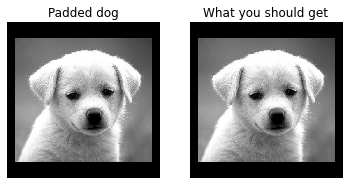

In [9]:
#from filters import zero_pad

pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)
print(padded_img.shape)


# Plot your padded dog
plt.subplot(121), plt.imshow(padded_img), plt.title('Padded dog'), plt.axis('off')

# Plot what you should get
solution_img = cv2.imread('img/padded_dog.jpg', 0)
plt.subplot(122), plt.imshow(solution_img), plt.title('What you should get'), plt.axis('off')

plt.show()

Далее, выполните функцию **`conv_fast`** в **`filters.py`** с помощью `zero_pad`. Запустите код ниже, чтобы сравнить результаты по двум реализациям. `conv_fast` должна работать значительно быстрее, чем `conv_nested`.  
В зависимости от вашей реализации и компьютера, `conv_nested` должен занять несколько секунд и `conv_fast` должен работать примерно в 5 раз быстрее.

In [10]:
def conv_fast(image, kernel, bh, bw):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    kernel = np.flip(np.flip(kernel,axis=1),axis=0)
    out = np.zeros((Hi, Wi))
    if bh == 0 and bw == 0:
        bh = int((Hk-1)/2)
        bw = int((Wk-1)/2)

    for x in range(bh, Hi-bh):
        for y in range(bw, Wi -bw):
            out[x,y] = np.sum(kernel*image[x-int((Hk-1)/2):x+int((Hk-1)/2)+1,y-int((Wk-1)/2):y+int((Wk-1)/2)+1])
            #for xk in range(-1*bh, bh+1):
                #for yk in range(-1*bw, bw+1):
                    #out[x][y] += image[x + xk][y+yk] * kernel[xk+bh][yk+bw]
    return out

conv_nested: took 3.076804 seconds.
conv_fast: took 0.667215 seconds.


(-0.5, 371.5, 379.5, -0.5)

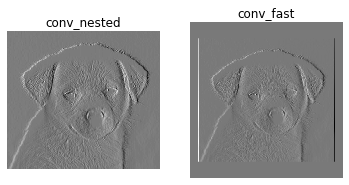

In [11]:
t0 = time()
out_fast = conv_fast(padded_img, kernel,pad_height,pad_width)
t1 = time()
out_nested = conv_nested(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

### Задание со звездочкой

Разработайте более быструю версию свертки и реализуйте **`conv_faster`** в **`filters.py`**. Вы заработаете дополнительный балл в том случае, если `conv_faster` будет работать быстрее (с достаточным запасом), чем `conv_fast` **и** выдаст тот же результат.

conv_fast: took 0.425863 seconds.
conv_faster: took 0.000998 seconds.


(-0.5, 331.5, 299.5, -0.5)

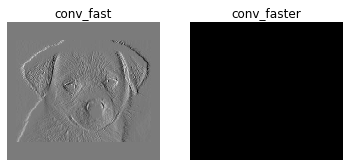

In [12]:
from filters import conv_faster

t0 = time()
out_fast = conv_fast(img, kernel,pad_height,pad_width)
t1 = time()
out_faster = conv_faster(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_fast: took %f seconds." % (t1 - t0))
print("conv_faster: took %f seconds." % (t2 - t1))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_faster)
plt.title('conv_faster')
plt.axis('off')

---
# Часть 2: Кросс-корреляция

Кросс-корреляция двух 2D сигналов $f$ и $g$ определяется следующим образом:
$$(f\star{g})[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot g[m-i,n-j]$$

## Проверка шаблона с помощью кросс-корреляцией 

Предположим, что ты продавщица в продуктовом магазине. Одна из ваших обязанностей - периодически проверять полки и складировать их всякий раз, когда есть распроданные товары. Вы устали от этой кропотливой работы и решили построить систему компьютерного зрения, которая отслеживает предметы на полке.

К счастью, в CS131 вы узнали, что для сопоставления шаблонов можно использовать кросс-корреляцию: шаблон $g$ умножается на регионы с большим изображением $f$, чтобы измерить, насколько каждый регион похож на шаблон.

Шаблон товара (`template.jpg`) и изображение полки (`shelf.jpg`) предоставляются. Мы будем использовать кросс-корреляцию, чтобы найти товар на полке.

Реализуйте функцию **`cross_correlation`** в **`filters.py`** и запустите код ниже.

*- Подсказка: Вы можете использовать функцию `conv_fast`, которую вы реализовали в предыдущем вопросе.

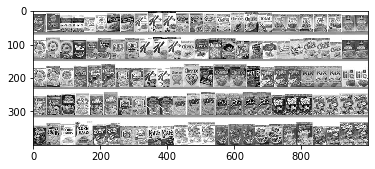

In [13]:
# Load template and image in grayscale
img = cv2.imread('img/shelf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grey = cv2.imread('img/shelf.jpg', 0)
temp = cv2.imread('img/template.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
temp_grey = cv2.imread('img/template.jpg', 0)
plt.imshow(img_grey)

In [14]:
def cross_correlation(f, g):
    out = np.zeros_like(f)
    
    out = conv_fast(f,np.flip(np.flip(g,axis=1), axis=0)[0:-1],0,0)

    return out

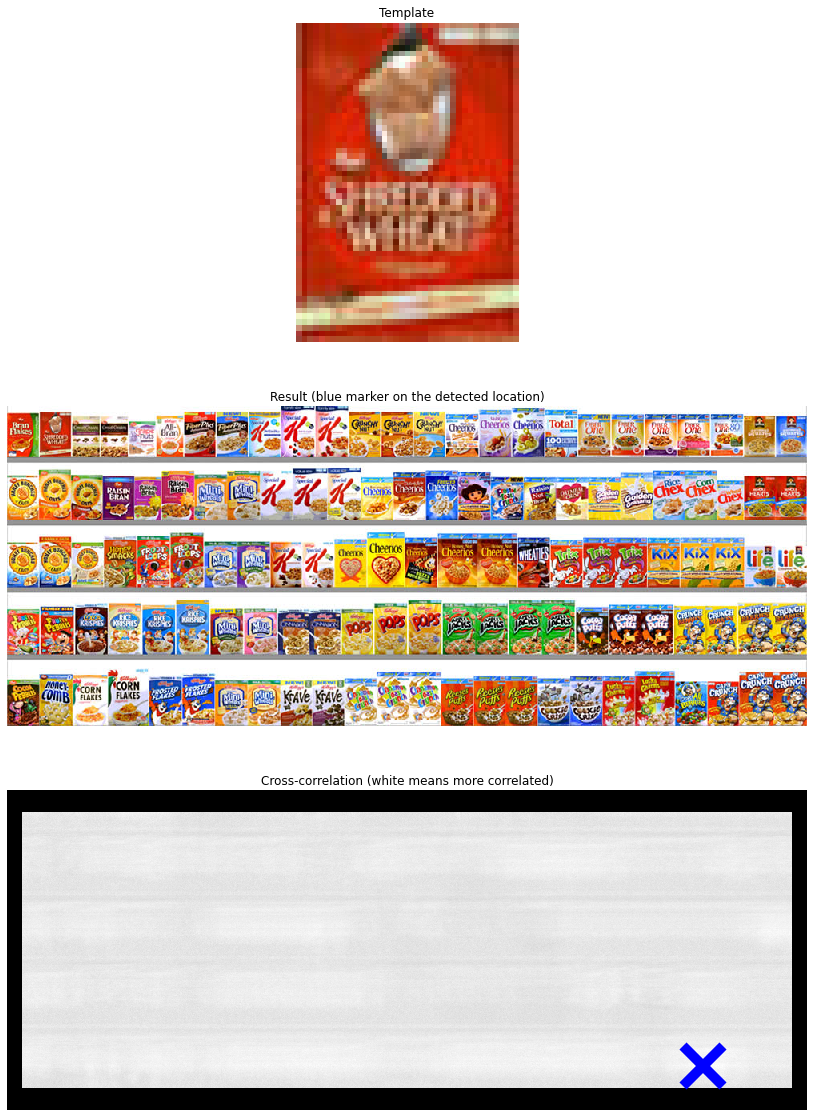

In [15]:
# Perform cross-correlation between the image and the template
out = cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(25, 20))

# Display product template
plt.subplot(311), plt.imshow(temp), plt.title('Template'), plt.axis('off') 

# Display image
plt.subplot(312), plt.imshow(img), plt.title('Result (blue marker on the detected location)'), plt.axis('off')

# Display cross-correlation output
plt.subplot(313), plt.imshow(out), plt.title('Cross-correlation (white means more correlated)'), plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)

plt.show()

### Интерпретация

Как выглядит вывод кросс-корреляционного фильтра? Способен ли он правильно определить продукт? Объясните, какие проблемы могут возникнуть при использовании необработанного шаблона в качестве фильтра.

**Ваш ответ:** вместо нужного объекта может найтись тот, кто будет больше схож по общим признакам(например:такой же красный и с какими-то надписями)

---
## Нулевая кросс-корреляция

Решение этой проблемы заключается в вычитании среднего значения шаблона так, чтобы оно имело нулевое среднее значение.

Реализуйте функцию **`zero_mean_cross_correlation`** в файле **`filters.py`** и запустите код ниже.

**Если ваша реализация корректна, то вы должны увидеть синий крест по центру от правильной коробки с хлопьями**.

In [16]:
def zero_mean_cross_correlation(f, g):
    out = np.zeros_like(f)
    
    out =  conv_fast(f, np.flip(np.flip(g-np.mean(g), axis=0), axis=1)[0:-1],0,0)

    return out

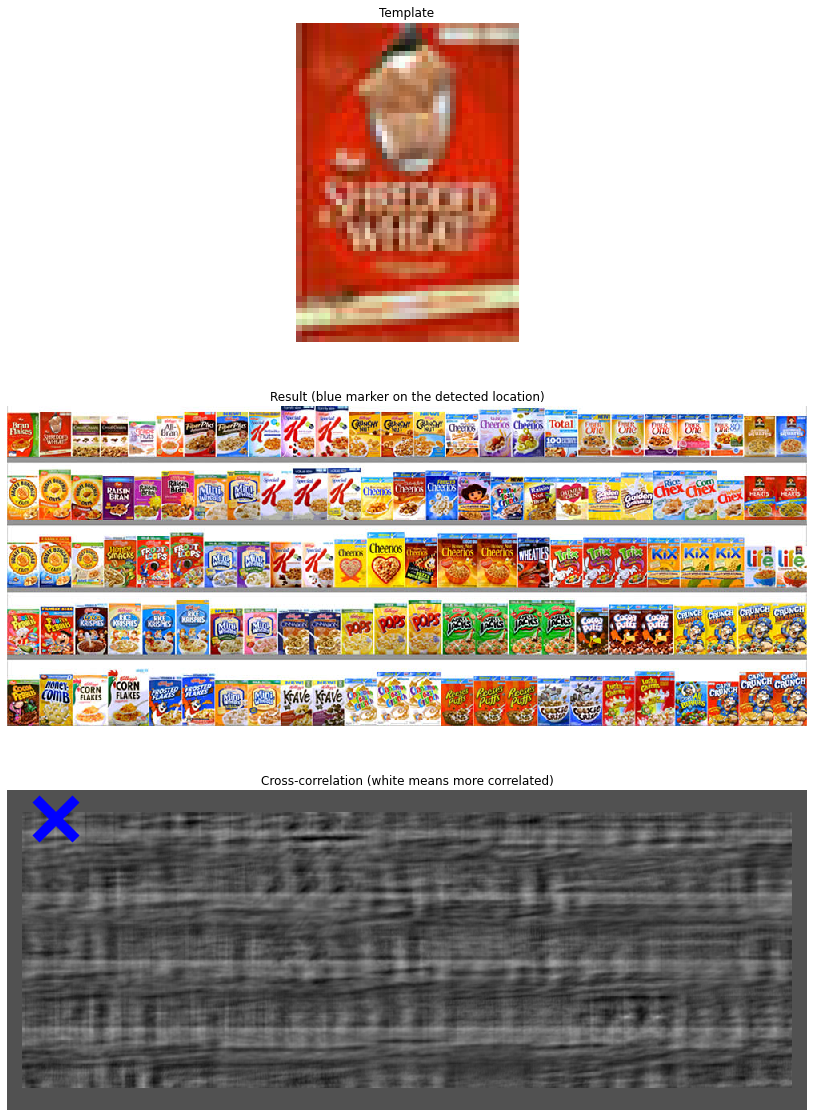

In [17]:
#from filters import zero_mean_cross_correlation

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(30, 20))

# Display product template
plt.subplot(311), plt.imshow(temp), plt.title('Template'), plt.axis('off')

# Display image
plt.subplot(312), plt.imshow(img), plt.title('Result (blue marker on the detected location)'), plt.axis('off')

# Display cross-correlation output
plt.subplot(313), plt.imshow(out), plt.title('Cross-correlation (white means more correlated)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)

plt.show()

Кроме того, можно определить наличие продукта с соответствующим масштабированием и пороговым значением.

In [18]:
def check_product_on_shelf(shelf, product):
    out = zero_mean_cross_correlation(shelf, product)
    
    # Scale output by the size of the template
    out = out / float(product.shape[0] * product.shape[1])
    
    # Threshold output (this is arbitrary, you would need to tune the threshold for a real application)
    out = out > 0.025
    
    if np.sum(out) > 0:
        print('The product is on the shelf')
    else:
        print('The product is not on the shelf')

In [19]:
# Load image of the shelf without the product
img2 = cv2.imread('img/shelf_soldout.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_grey = cv2.imread('img/shelf_soldout.jpg', 0)

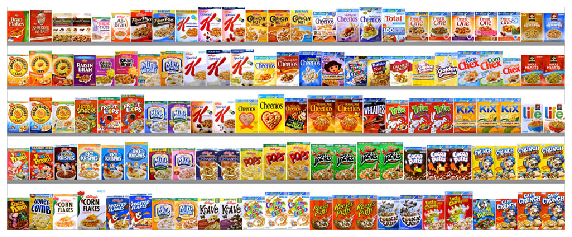

The product is on the shelf


In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(img), plt.axis('off'), plt.show()
check_product_on_shelf(img_grey, temp_grey)

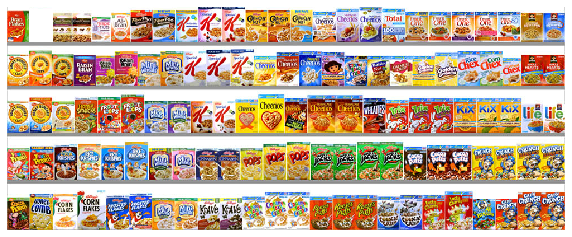

The product is on the shelf


In [21]:
plt.figure(figsize=(10, 5))
plt.imshow(img2), plt.axis('off'), plt.show()
check_product_on_shelf(img2_grey, temp_grey)

---
## Нормализованная кросс-корреляция
Однажды свет возле полки погаснет, и устройство слежения за продуктами начнет работать неисправно. `zero_mean_cross_correlation` не устойчива к изменению состояния освещения. Код, приведенный ниже, демонстрирует это.

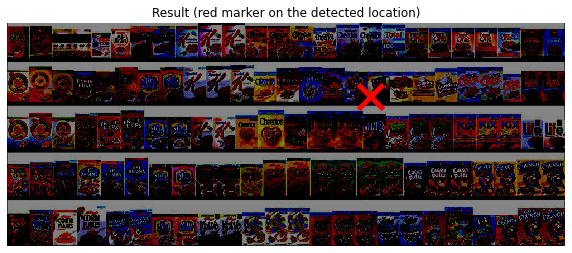

In [22]:
from filters import normalized_cross_correlation

# Load image
img = cv2.imread('img/shelf_dark.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grey = cv2.imread('img/shelf_dark.jpg', 0)

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(10, 5))

# Display image
plt.imshow(img), plt.title('Result (red marker on the detected location)'), plt.axis('off')
# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

Решение заключается в нормализации пикселей изображения и шаблона на каждом шаге перед их сравнением. Это называется **нормализованной кросс-корреляцией**.

Математическим определением нормализованной кросс-корреляции является $f$ и шаблон $g$:
$$(f\star{g})[m,n]=\sum_{i,j} \frac{f[i,j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}} \cdot \frac{g[i-m,j-n]-\overline{g}}{\sigma_g}$$

Где:
- $f_{m,n}$ - это патч-изображение в позиции $(m,n)$
- $\overline{f_{m,n}}$ - это среднее значение изображения патча $f_{m,n}$.
- $\sigma_{f_{m,n}}$ - стандартное отклонение изображения патча $f_{m,n}$ 
- $\overline{g}$ - это среднее значение шаблона $g$.
- $\sigma_g$ - стандартное отклонение шаблона $g$.

Реализуйте функцию **`normalized_cross_correlation`** в файле **`filters.py`** и запустите код ниже.

In [36]:
def normalized_cross_correlation(f, g):
    out = np.zeros_like(f)
    temp = np.zeros_like(f)
    cv2.normalize(f,temp,0,255,cv2.NORM_MINMAX)
    #plt.imshow(temp)
    Hi, Wi = f.shape
    Hk, Wk = g.shape
    out = np.zeros((Hi, Wi))
    bh = int((Hk-1)/2)
    bw = int((Wk-1)/2)

    for x in range(bh, Hi-bh):
        for y in range(bw, Wi -bw):
            out[x,y] = np.sum((temp[x][y]-np.mean(temp[x-int((Hk-1)/2):x+int((Hk-1)/2)+1,y-int((Wk-1)/2):y+int((Wk-1)/2)+1]))/np.std(temp[x-int((Hk-1)/2):x+int((Hk-1)/2)+1,y-int((Wk-1)/2):y+int((Wk-1)/2)+1])*(g-np.mean(g))/np.std(g))
    
    return out

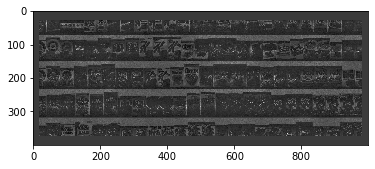

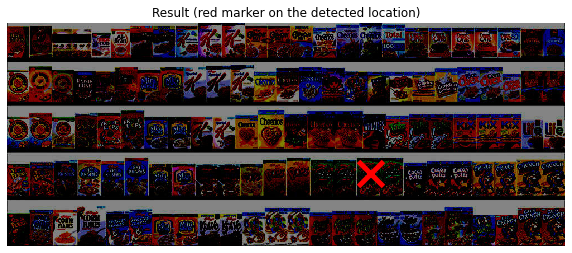

In [37]:
#from filters import normalized_cross_correlation

out = np.zeros_like(img_grey)
# Perform normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(10, 5))

# Display image
plt.imshow(img), plt.title('Result (red marker on the detected location)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()